# Market quota game

## Simulating SNP500 data

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime, timedelta
import pandas as pd

In [60]:
pd.date_range(start=datetime.now(), periods=n, freq="10ms")

DatetimeIndex(['2025-09-14 12:12:26.684946', '2025-09-14 12:12:26.694946',
               '2025-09-14 12:12:26.704946', '2025-09-14 12:12:26.714946',
               '2025-09-14 12:12:26.724946', '2025-09-14 12:12:26.734946',
               '2025-09-14 12:12:26.744946', '2025-09-14 12:12:26.754946',
               '2025-09-14 12:12:26.764946', '2025-09-14 12:12:26.774946',
               ...
               '2025-09-14 12:22:26.584946', '2025-09-14 12:22:26.594946',
               '2025-09-14 12:22:26.604946', '2025-09-14 12:22:26.614946',
               '2025-09-14 12:22:26.624946', '2025-09-14 12:22:26.634946',
               '2025-09-14 12:22:26.644946', '2025-09-14 12:22:26.654946',
               '2025-09-14 12:22:26.664946', '2025-09-14 12:22:26.674946'],
              dtype='datetime64[ns]', length=60000, freq='10L')

In [82]:
r = 0.01
s = 0.1474
S0 = 100
m = r - 0.5*s*s
dt = 1/365/24/60/60/100 #10 ms
n = 100*60*1

In [88]:
def geom_brownian_motion(S0, m, s, n, dt):
    logret = np.random.normal(m * dt, s * np.sqrt(dt), size=int(n))
    ret = np.exp(logret.cumsum())
    price = S0*ret
    return price

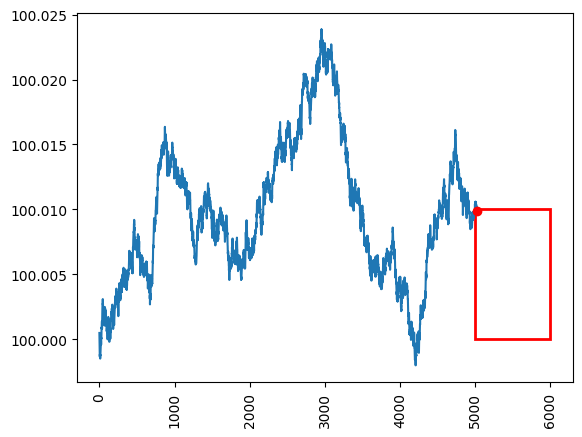

In [179]:
t = np.arange(n)
S = geom_brownian_motion(S0, m, s, n, dt)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.ticklabel_format(style='plain', axis='y')


rect = patches.Rectangle((5000, S0), 1000, 0.01, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

x0, y0, x1, y1 = rect.get_x(), rect.get_y(), rect.get_x() + rect.get_width(), rect.get_y() + rect.get_height()

mask = (t >= x0) & (t <= x1) & (S >= y0) & (S <= y1)

points_inside = np.column_stack((t[mask], S[mask]))

hit = len(points_inside)

if hit:
    first_x, first_y = points_inside[0]
    ax.scatter(first_x, first_y, color="red", zorder=5, label="First inside point")

    ax.plot(t[:int(first_x)], S[:int(first_x)])
else:
    ax.plot(t, S)
    

plt.show()

In [ ]:

rect_vals

{'x0': 5000, 'y0': 100, 'x1': 6000, 'y1': 100.01}

In [123]:
x0, y0, x1, y1 = rect_vals.values()

# np.any((t >= x0) & (t <= x1) & (S >= y0) & (S <= y1))
mask = (t >= x0) & (t <= x1) & (S >= y0) & (S <= y1)
points_inside = np.column_stack((t[mask], S[mask]))
points_inside

array([[5000.        ,  100.00438007],
       [5001.        ,  100.00420986],
       [5002.        ,  100.00399318],
       [5003.        ,  100.0043099 ],
       [5004.        ,  100.00453665],
       [5005.        ,  100.00570393],
       [5006.        ,  100.00554988],
       [5007.        ,  100.00569767],
       [5008.        ,  100.00599073],
       [5009.        ,  100.00590948],
       [5010.        ,  100.00587988],
       [5011.        ,  100.00566929],
       [5012.        ,  100.00558093],
       [5013.        ,  100.00495285],
       [5014.        ,  100.00461595],
       [5015.        ,  100.00459459],
       [5016.        ,  100.00441892],
       [5017.        ,  100.00471325],
       [5018.        ,  100.00426307],
       [5019.        ,  100.0042744 ],
       [5020.        ,  100.00430752],
       [5021.        ,  100.00393032],
       [5022.        ,  100.0038674 ],
       [5023.        ,  100.00302726],
       [5024.        ,  100.00320877],
       [5025.        ,  1